In [7]:
import pennylane as qml
from pennylane import numpy as np
import datetime
import matplotlib.pyplot as plt

# Predefined classes/functions

In [9]:
def get_operator(mu, sigma, q, budget, penalty):  # pylint: disable=invalid-name
    """ get qubit op """
    # pylint: disable=invalid-name
    # get problem dimension
    n = len(mu)
    e = np.ones(n)
    E = np.matmul(np.asmatrix(e).T, np.asmatrix(e))

    # map problem to Ising model
    offset = -1 * np.dot(mu, e) / 2 + penalty * budget ** 2 - \
        budget * n * penalty + n ** 2 * penalty / 4 + q / 4 * np.dot(e, np.dot(sigma, e))
    mu_z = mu / 2 + budget * penalty * e - n * penalty / 2 * e - q / 2 * np.dot(sigma, e)
    sigma_z = penalty / 4 * E + q / 4 * sigma

    # construct operator
    pauli_list = []
    for i in range(n):
        i_ = i
        # i_ = n - i - 1
        if np.abs(mu_z[i_]) > 1e-6:
            xp = np.zeros(n, dtype=bool)
            zp = np.zeros(n, dtype=bool)
            zp[i_] = True
            pauli_list.append([mu_z[i_], Pauli(zp, xp)])
        for j in range(i):
            j_ = j
            # j_ = n-j-1
            if np.abs(sigma_z[i_, j_]) > 1e-6:
                xp = np.zeros(n, dtype=bool)
                zp = np.zeros(n, dtype=bool)
                zp[i_] = True
                zp[j_] = True
                pauli_list.append([2 * sigma_z[i_, j_], Pauli(zp, xp)])
        offset += sigma_z[i_, i_]

    return WeightedPauliOperator(paulis=pauli_list), offset

In [15]:
from abc import ABC, abstractmethod
from typing import Tuple, Optional, List, cast, Union
import logging
from enum import Enum

import numpy as np
import fastdtw


class StockMarket(Enum):
    """ Stock Market enum """
    LONDON = 'XLON'
    EURONEXT = 'XPAR'
    SINGAPORE = 'XSES'


class BaseDataProvider(ABC):
    @abstractmethod
    def __init__(self) -> None:
        self._data = None  # type: Optional[List]
        self._n = 0  # pylint: disable=invalid-name
        self.period_return_mean: Optional[np.ndarray] = None
        self.cov = None
        self.period_return_cov = None
        self.rho: Optional[np.ndarray] = None
        self.mean: Optional[np.ndarray] = None

    @abstractmethod
    def run(self) -> None:
        """ Loads data. """
        pass

    # it does not have to be overridden in non-abstract derived classes.
    def get_mean_vector(self) -> np.ndarray:
        """ Returns a vector containing the mean value of each asset."""
        self.mean = cast(np.ndarray, np.mean(self._data, axis=1))
        return self.mean

    @staticmethod
    def _divide(val_1, val_2):
        if val_2 == 0:
            if val_1 == 0:
                return 1
            logger.warning('Division by 0 on values %f and %f', val_1, val_2)
            return np.nan
        return val_1 / val_2

    # it does not have to be overridden in non-abstract derived classes.
    def get_period_return_mean_vector(self) -> np.ndarray:
        """
        Returns a vector containing the mean value of each asset.
        Returns:
            a per-asset mean vector.
        """
        _div_func = np.vectorize(BaseDataProvider._divide)
        period_returns = _div_func(np.array(self._data)[:, 1:], np.array(self._data)[:, :-1]) - 1
        self.period_return_mean = cast(np.ndarray, np.mean(period_returns, axis=1))
        return self.period_return_mean

    # it does not have to be overridden in non-abstract derived classes.

    # it does not have to be overridden in non-abstract derived classes.
    def get_period_return_covariance_matrix(self) -> np.ndarray:
        """
        Returns a vector containing the mean value of each asset.
        Returns:
            a per-asset mean vector.
        """
        _div_func = np.vectorize(BaseDataProvider._divide)
        period_returns = _div_func(np.array(self._data)[:, 1:], np.array(self._data)[:, :-1]) - 1
        self.period_return_cov = np.cov(period_returns)
        return self.period_return_cov

    # it does not have to be overridden in non-abstract derived classes.
    def get_similarity_matrix(self) -> np.ndarray:
        """
        Returns time-series similarity matrix computed using dynamic time warping.
        Returns:
            an asset-to-asset similarity matrix.
        """
        self.rho = np.zeros((self._n, self._n))
        for i_i in range(0, self._n):
            self.rho[i_i, i_i] = 1.
            for j_j in range(i_i + 1, self._n):
                this_rho, _ = fastdtw.fastdtw(self._data[i_i], self._data[j_j])
                this_rho = 1.0 / this_rho
                self.rho[i_i, j_j] = this_rho
                self.rho[j_j, i_i] = this_rho
        return self.rho

In [20]:
from qiskit.aqua import MissingOptionalLibraryError

logger = logging.getLogger(__name__)


class RandomDataProvider(BaseDataProvider):
    """Pseudo-randomly generated mock stock-market data provider.
    """

    def __init__(self,
                 tickers: Optional[Union[str, List[str]]] = None,
                 start: datetime.datetime = datetime.datetime(2016, 1, 1),
                 end: datetime.datetime = datetime.datetime(2016, 1, 30),
                 seed: Optional[int] = None) -> None:
        """
        Initializer
        Args:
            tickers: tickers
            start: first data point
            end: last data point precedes this date
            seed: shall a seed be used?
        """
        super().__init__()
        if not _HAS_PANDAS:
            raise MissingOptionalLibraryError(
                libname='Pandas',
                name='RandomDataProvider',
                pip_install='pip install pandas')
        tickers = tickers if tickers is not None else ["TICKER1", "TICKER2"]
        if isinstance(tickers, list):
            self._tickers = tickers
        else:
            self._tickers = tickers.replace('\n', ';').split(";")
        self._n = len(self._tickers)

        self._start = start
        self._end = end
        self._seed = seed

    def run(self) -> None:
        """
        Generates data pseudo-randomly, thus enabling get_similarity_matrix
        and get_covariance_matrix methods in the base class.
        """

        length = (self._end - self._start).days
        generator = np.random.default_rng(self._seed)
        self._data = []
        for _ in self._tickers:
            d_f = pd.DataFrame(
                generator.standard_normal(length)).cumsum() + generator.integers(1, 101)
            trimmed = np.maximum(d_f[0].values, np.zeros(len(d_f[0].values)))
            trimmed_list = trimmed.tolist()
            # find index of first 0 element
            zero_idx = next((idx for idx, val in enumerate(trimmed_list) if val == 0), -1)
            if zero_idx >= 0:
                # set to 0 all values after first 0
                trimmed_list = \
                    [val if idx < zero_idx else 0 for idx, val in enumerate(trimmed_list)]
            self._data.append(trimmed_list)

# Implementation

In [28]:
# set number of assets (= number of qubits)
num_assets = 2

# Generate expected return and covariance matrix from (random) time-series
# stocks = [("TICKER%s" % i) for i in range(num_assets)]
stocks = ["GOOG", "FB"]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2020,1,1),
                 end=datetime.datetime(2021,2,15))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

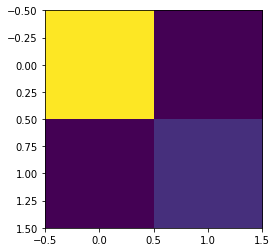

In [29]:
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [ ]:
q = 0.5                   # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

qubitOp, offset = get_operator(mu, sigma, q, budget, penalty)

In [ ]:
dev = qml.device("default.qubit", wires=num_assets)
N_LAYERS = 3
# Get cost and mixer Hams
cost_ham, mixer_ham = qml.qaoa(qubitOp) 

def qaoa_layer(gamma, alpha):
        qml.qaoa.cost_layer(gamma, cost_h)
        qml.qaoa.mixer_layer(alpha, mixer_h)


@qml.qnode(dev)
def circuit(params):
    for wire in range(num_assets):
        qml.Hadamard(wires=wire)
    qml.layer(qaoa_layer, N_LAYERS, params[0], params[1])
    probs = qml.probs(wires=[x for x in range(num_assets)])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

def qaoa_portfolio(n_layers, budget):
    init_params = 0.01 * np.random.rand(num_assets, num_assets)
    
    # Objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        # Obj function goes here -- thinking of doing ((1**T)x - B)**2 where B is budget, and T is time length
        return neg_obj
    
    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

# Convert optimal params into which assets to buy
print_result(params)